# Data Augmentation

Hasta ahora, se ha seleccionado una arquitectura de modelo diseñada para reconocer características importantes en las imágenes. La precisión de la validación sigue estando por detrás de la precisión del entrenamiento, lo que es un signo de sobreajuste: el modelo se confunde con cosas que no ha visto antes cuando se prueba con el conjunto de datos de validación.

Para enseñar a este modelo a ser más robusto ante nuevos datos, se va a aumentar mediante programación el tamaño y la varianza del conjunto de datos. Esto se conoce como [*Data Augmentation (aumento de datos)*](https://link.springer.com/article/10.1186/s40537-019-0197-0), una técnica útil para muchas aplicaciones de Deep Learning.

El *Data Augmentation* proporciona al modelo más imágenes de las que aprender durante el entrenamiento. El aumento de la varianza ayuda al modelo a ignorar las características sin importancia y a seleccionar solo las características que son verdaderamente importantes en la clasificación, lo que le permite generalizar mejor.

## Objetivos

* Aumentar el conjunto de datos
* Utilizar los datos aumentados para entrenar un modelo mejorado.
* Guardar el modelo entrenado en el disco para utilizarlo en el despliegue.

## Preparación de los datos

Se cargan y procesan los datos :

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Carga de datos de archivos CSV
train_df = pd.read_csv("datasets/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("datasets/asl_data/sign_mnist_valid.csv")


# Separamos los valores objetivo
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

2025-03-13 11:50:09.787738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741866609.812544   29784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741866609.819452   29784 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 11:50:09.841939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Separamos los vectores de imagen en x_train y x_valid
x_train = train_df.values
x_valid = valid_df.values

In [3]:
# La forma de las imágenes es 28x28, es decir, 784 pixeles
print(x_train.shape)
print(x_valid.shape)

(27455, 784)
(7172, 784)


In [4]:
# Categorizamos los objetivos escalares en categorías binaria (one-hot encoding)

num_classes = 24 # 24 letras en el alfabeto de señas
#One-hot encoding para transformar los labels en vectores de 0s y 1s
y_train = keras.utils.to_categorical(y_train, num_classes) 
y_valid = keras.utils.to_categorical(y_valid, num_classes) 

print(y_train.shape)
print(y_valid.shape)

(27455, 24)
(7172, 24)


In [5]:



# Normalizamos los datos de imagen dividiendo por 255 para que los valores estén entre 0 y 1
x_train = x_train / 255 
x_valid = x_valid / 255


# Cambiamos la forma de los datos de imagen para la red convolucional
# (número de imágenes, ancho, alto, canales):
#  -1 significa que el tamaño de esa dimensión se calculará automáticamente
#   1 canal porque las imágenes son en escala de grises
#   28x28 es el tamaño de la imagen
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## Construcción del modelo

Se crea el modelo en la siguiente celda.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-13 11:50:59.803325: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Data Augmentation

Antes de compilar el modelo, es hora de configurar el *"aumento de datos"*.

Keras viene con una clase de *aumento de imagen* llamada `ImageDataGenerator`. Es recomendable consultar la [documentación aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Esta clase acepta una serie de opciones para aumentar los datos. En la celda siguiente se encuentra el código para crear una instancia de la clase:

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # girar aleatoriamente imágenes en el rango (grados, 0 a 180)
    zoom_range=0.1,  # Zoom aleatorio de la imagen
    width_shift_range=0.1,  # desplazar aleatoriamente las imágenes horizontalmente (fracción del ancho total)
    height_shift_range=0.1,  # desplazar aleatoriamente las imágenes verticalmente (fracción de la altura total)
    horizontal_flip=True,  # voltear aleatoriamente las imágenes horizontalmente
    vertical_flip=False) # no voltear aleatoriamente las imágenes verticalmente


#### NOTA:   

Si nos paramos un momento para pensar por qué se puede necesitar/querer voltear las imágenes horizontalmente, pero no verticalmente, se debe considerar el hecho de que el conjunto de datos son imágenes de manos "describiendo" el alfabeto.    
Si se desea utilizar este modelo para clasificar imágenes de manos más adelante, es poco probable que esas manos estén al revés, pero podrían ser zurdas. Este tipo de razonamiento específico del dominio puede ayudar a tomar buenas decisiones para tus propias aplicaciones de aprendizaje profundo.

## Batch Size   

Otra ventaja del `ImageDataGenerator` es que [agrupa](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) los datos para que el modelo pueda entrenarse con una muestra aleatoria.

Los lotes actúan como un juego de cartas. Se baraja todo el conjunto de datos para que la probabilidad de extraer cualquier entidad de datos sea [verdaderamente aleatoria](http://sites.utexas.edu/sos/random/). En cada paso del entrenamiento, se extrae un número de elementos igual al tamaño del lote y se utilizan para entrenar el modelo. Como el lote es una muestra aleatoria, puede hacer un buen trabajo representando todos los datos aunque sea una pequeña fracción de todo el conjunto. 

En la práctica, un tamaño de lote de 32 o 64 elementos da buenos resultados.    
En la celda de abajo se dispone el código para ver con qué tipo de lotes se va a entrenar nuestro modelo.   

¿Es este sistema lo suficientemente aleatorio? ¿Son todas las imágenes letras reconocibles?

In [9]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

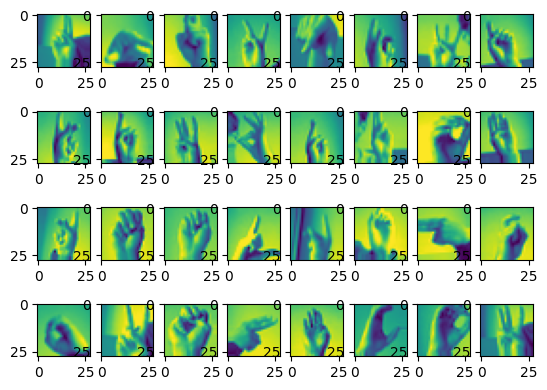

In [10]:
x, y = next(img_iter)
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Ajustando los datos para el Generador

A continuación, el generador debe ajustarse al conjunto de datos de entrenamiento.

In [11]:
datagen.fit(x_train)

## Compilación del modelo

Una vez creada la instancia del generador de datos y ajustada a los datos de entrenamiento, ya se puede compilar el modelo:

In [13]:
# Compilamos el modelo usando la función de pérdida categórica de entropía cruzada y la métrica de precisión
# para la clasificación de múltiples clases
model.compile(loss='categorical_crossentropy', metrics=['accuracy']) 

## Entrenamiento con Datos Aumentados

Cuando se utiliza un generador de datos de imagen con Keras, el modelo se entrena de forma un poco diferente:    
- en lugar de simplemente pasar los conjuntos de datos `x_train` y `y_train` al modelo, se pasa el generador, llamando al método [flow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) del generador. Esto hace que las imágenes se aumenten en vivo y en memoria justo antes de pasarlas al modelo para el entrenamiento.

Los generadores pueden suministrar una cantidad indefinida de datos, y cuando se usan para entrenar los datos, se debe establecer explícitamente cuánto tiempo se quiere que dure cada época, o de lo contrario la época continuará indefinidamente, con el generador creando un número indefinido de imágenes aumentadas para proporcionar al modelo.

Se establece explícitamente cuánto tiempo se quiere que dure cada época utilizando el argumento `steps_per_epoch`. Dado que `pasos * tamaño_lote = número_de_imágenes_entrenadas en una época` una práctica común, que se usa en este caso, es establecer el número de pasos igual al tamaño del conjunto de datos no aumentado dividido por el tamaño_lote (que tiene un valor por defecto de 32).

Al ejecutar la siguiente celda se podrán ver los resultados. El entrenamiento tardará más dado que ahora se está entrenando con más datos:

In [14]:
model.fit(img_iter,
          epochs=10,
          steps_per_epoch=int(len(x_train)/batch_size), # Ejecutamos el mismo número de pasos que si no usáramos un generador.
          validation_data=(x_valid, y_valid))

Epoch 1/10


/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


857/857 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.4427 - loss: 1.8657 - val_accuracy: 0.8550 - val_loss: 0.4315
Epoch 2/10
  1/857 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - accuracy: 0.7812 - loss: 0.4879

/usr/local/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7812 - loss: 0.4879 - val_accuracy: 0.8366 - val_loss: 0.5153
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.8785 - loss: 0.3611 - val_accuracy: 0.9353 - val_loss: 0.1936
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8750 - loss: 0.3123 - val_accuracy: 0.8087 - val_loss: 0.6404
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.9279 - loss: 0.2140 - val_accuracy: 0.9399 - val_loss: 0.1964
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9688 - loss: 0.1199 - val_accuracy: 0.9158 - val_loss: 0.2608
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9522 - loss: 0.1462 - val_accuracy: 0.9668 - val_loss: 0.0867
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8750 - loss: 0.2862 - val_accuracy: 0.9654 - val_loss: 0.0951
Epoch 9/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9584 - loss: 0.1279 - val_accuracy: 0.955

## Resultados

Se puede observar que la precisión de la validación es mayor y más coherente. Esto significa que este modelo ya no se sobreajusta, sino que generaliza mejor y hace mejores predicciones con nuevos datos.

## Guardando el modelo

Ahora que se dispone de un modelo bien entrenado, se intentará desplegarlo para realizar inferencias sobre nuevas imágenes.

Es común, una vez que se tiene un modelo entrenado con el que se está satisfecho, guardarlo en disco.

Guardar el modelo en Keras es bastante sencillo utilizando el método `save`. Hay diferentes formatos en los que se puede guardar, pero se utilizará el predeterminado por ahora. Si se desea, se puede consultar [la documentación](https://www.tensorflow.org/guide/keras/save_and_serialize). En el siguiente cuaderno, se cargará el modelo y se utilizará para leer nuevas imágenes del lenguaje de signos:

In [15]:
model.save('asl_model.keras')